<a href="https://colab.research.google.com/github/ASi-F/NLPlay-with-Transformers/blob/main/RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RoBERTa**

In [ ]:
pip install transformers

In [ ]:
pip install datasets

In [3]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import random 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Preprocessing**

The dataset is mounted from drive and some basic preprocessing is done to remove html tags. The review and sentiment columns are replaced by text and label columns. Here we convert the pandas df to dataset to pytorch dataloader

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [6]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final

df['text'] = df['review'].apply(remove_tags)

In [7]:
df = df.drop('review',axis = 1)

In [8]:
df['label'] = [ 1*(sent=='positive') for sent in df['sentiment']]

df = df.drop('sentiment', axis = 1)

In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [10]:
train_range = [i for i in range(0,20000) if 6>=i%10 and i%10>=0]
eval_range = [i for i in range(0,20000) if 9>=i%10 and i%10>=7]

train_dataset = dataset.select(train_range).shuffle(seed=42)
eval_dataset = dataset.select(eval_range) .shuffle(seed=42)

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=5)
eval_dataloader = DataLoader(eval_dataset, batch_size=5)

## **Architecture**

In [12]:
from transformers import AutoModel
from transformers import AutoTokenizer

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [15]:
class Classifier(nn.Module):
  def __init__(self,hidden_dim,output_size,model_name,enc_dim):
    super(Classifier,self).__init__()

    self.model = AutoModel.from_pretrained(model_name, num_labels=2)
  
    self.LF1 = nn.Linear(enc_dim,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)    

## **Training**

In [16]:
from tqdm.auto import tqdm

def train_classifier(num_epochs,train_dataloader,optimizer,classifier,tokenizer,loss_function = nn.CrossEntropyLoss()):
  losses = []
  num_training_steps = num_epochs*len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  classifier.ready_train()
  i = 0
  avg_loss = 0.
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      # forward prop
      inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
      inp = inp.to(device)
      out = classifier(inp)
      pred = batch['label']
      pred = pred.to(device)
      loss = loss_function(out, pred)

      # backward prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      progress_bar.update(1)
      if i%(5 *(num_training_steps//100)) == 0  and i>0:
        print("TRAINING:{0} %\t AVEREAGE LOSS: {1}".format(i//(num_training_steps//100),avg_loss/(5*(num_training_steps//100))))
        avg_loss = 0
      i+=1
      avg_loss = avg_loss + float(loss.item())
  return losses

## **Model Evaluation**

In [17]:
plt.rcParams['figure.figsize'] = (15,10)
plt.style.use('ggplot')

def plot_loss(losses):
  x = [i for i in range(0,len(losses))]
  plt.plot(x,losses)
  plt.title('Training Loss')
  plt.ylabel('Loss')
  plt.xlabel('Batch Index')

def smooth_loss(losses,f):
  y = [0]*len(losses)
  for i in range(0,f):
    y[i] = (sum(losses[:i+1+f]))/(i+1+f)
  for i in range(f,len(losses)-f-1):
    y[i] = (sum(losses[i-f:i+f+1]))/(2*f+1)
  for i in range(len(losses)-f-1,len(losses)):
    y[i] = (sum(losses[i-f:]))/(len(losses)-i+f)
  plot_loss(y)

In [18]:
def acc(dataloader,classifier,tokenizer):
  corr = 0
  tot = len(dataloader)*10
  for batch in dataloader:
  # forward prop
    inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
    inp = inp.to(device)
    out = list(torch.argmax(classifier(inp),dim=1))
    exp = list(batch['label'])
    
    for i,x in enumerate(out):
      if x == exp[i]:
        corr = corr+1
    
  return 100*(corr/tot)

## **Model Initialization**

In [ ]:
model_name = 'roberta-base'
output_size = 2
hidden_dim = 500
enc_dim = 768

roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier_roberta = Classifier(hidden_dim,output_size,model_name,enc_dim)
classifier_roberta.to(device)

In [20]:
num_epochs = 2
lr = 1e-2
optimizer = optim.SGD(classifier_roberta.parameters(), lr)

losses = train_classifier(num_epochs,train_dataloader,optimizer,classifier_roberta,roberta_tokenizer)

  0%|          | 0/5600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


TRAINING:5 %	 AVEREAGE LOSS: 0.6926622814365796
TRAINING:10 %	 AVEREAGE LOSS: 0.6933448195457459
TRAINING:15 %	 AVEREAGE LOSS: 0.6936005639178412
TRAINING:20 %	 AVEREAGE LOSS: 0.6929335966706276
TRAINING:25 %	 AVEREAGE LOSS: 0.6929734387568065
TRAINING:30 %	 AVEREAGE LOSS: 0.6930123674018043
TRAINING:35 %	 AVEREAGE LOSS: 0.6931973519069808
TRAINING:40 %	 AVEREAGE LOSS: 0.6930487000516483
TRAINING:45 %	 AVEREAGE LOSS: 0.6929383158683777
TRAINING:50 %	 AVEREAGE LOSS: 0.6930294445582799
TRAINING:55 %	 AVEREAGE LOSS: 0.692886700800487
TRAINING:60 %	 AVEREAGE LOSS: 0.6930266144020217
TRAINING:65 %	 AVEREAGE LOSS: 0.6924867653420993
TRAINING:70 %	 AVEREAGE LOSS: 0.6925356243337903
TRAINING:75 %	 AVEREAGE LOSS: 0.6922293541686876
TRAINING:80 %	 AVEREAGE LOSS: 0.6928634396621159
TRAINING:85 %	 AVEREAGE LOSS: 0.6925325327685901
TRAINING:90 %	 AVEREAGE LOSS: 0.6919778992022787
TRAINING:95 %	 AVEREAGE LOSS: 0.6909752258232662


## **Plot for average loss per 100 iterations**

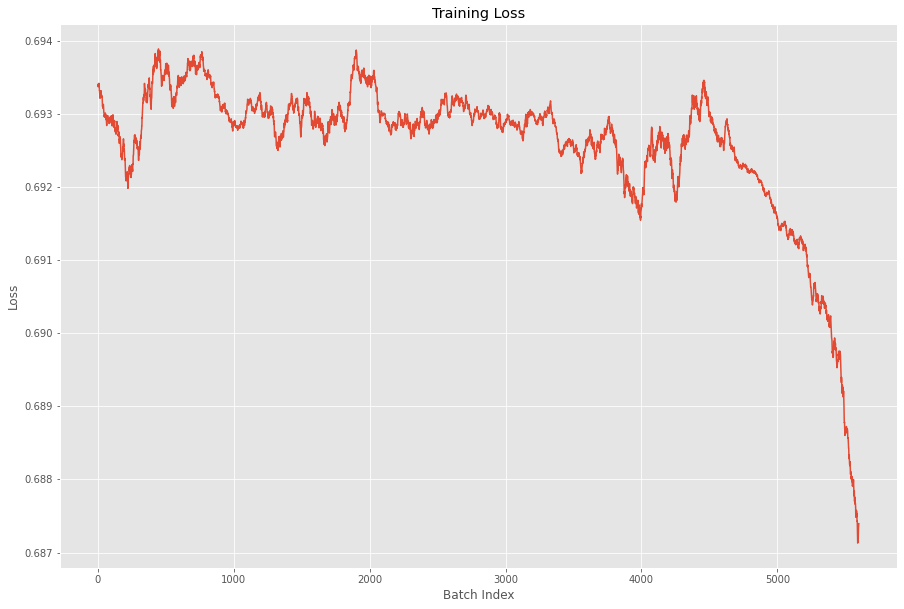

In [21]:
smooth_loss(losses,100)

## **Training set Accuracy**

In [22]:
classifier_roberta.ready_eval()

In [23]:
acc(train_dataloader,classifier_roberta,roberta_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


25.239285714285714

## **Test set accuracy**

In [24]:
acc(eval_dataloader,classifier_roberta,roberta_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


25.258333333333333